In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np

import amrex
import impactx
from impactx import ImpactX, RefPart, distribution, elements

In [3]:
pp_amr = amrex.ParmParse("amr")
pp_amr.add("max_level", 1)
pp_amr.addarr("n_cell", [32, 32, 32])
pp_geo = amrex.ParmParse("geometry")
pp_geo.addarr("prob_lo", [-15e-4, -15e-4, -3e-6])
pp_geo.addarr("prob_hi", [ 15e-4,  15e-4,  3e-6])
pp_geo.addarr("fine_tag_lo", [-7.4e-4, -7.4e-4, -1.4e-6])
pp_geo.addarr("fine_tag_hi", [ 7.4e-4,  7.4e-4,  1.4e-6])

In [4]:
sim = ImpactX()

MPI initialized with 1 MPI processes
MPI initialized with thread support level 3
OMP initialized with 8 OMP threads
AMReX (22.09-11-g9aa23c202a13) initialized


In [5]:
sim.set_particle_shape(2)  # B-spline order
sim.set_space_charge(True)
sim.dynamic_size = False
sim.set_diagnostics(False)

In [6]:
sim.domain

<amrex.RealBox (RealBox -0.0015 0.0015 -0.0015 0.0015 -3e-06 3e-06 )>

In [8]:
#sim.domain = amrex.RealBox((-15e-4, -15e-4, -3e-6), (15e-4,  15e-4,  3e-6))
#sim.domain

In [10]:
sim.init_grids()

boxArray(0) (BoxArray maxbox(1)
       m_ref->m_hash_sig(0)
       ((0,0,0) (31,31,31) (0,0,0)) )


Grids Summary:
  Level 0   1 grids  32768 cells  100 % of domain
  Level 1   4 grids  73728 cells  28.125 % of domain
            smallest grid: 16 x 16 x 32  biggest grid: 32 x 32 x 32



In [11]:
# load a 2 GeV electron beam with an initial
# unnormalized rms emittance of 2 nm
energy_MeV = 250  # reference energy
bunch_charge_C = 1.0e-9  # used with space charge
npart = 10000  # number of macro particles

#   reference particle
ref = sim.particle_container().ref_particle()
ref.set_charge_qe(-1.0).set_mass_MeV(0.510998950).set_energy_MeV(energy_MeV)

#   particle bunch
distr = distribution.Waterbag(
    sigmaX=4.472135955e-4,
    sigmaY=4.472135955e-4,
    sigmaT=9.12241869e-7,
    sigmaPx=0.0,
    sigmaPy=0.0,
    sigmaPt=0.0,
)
sim.add_particles(bunch_charge_C, distr, npart)

In [12]:
# design the accelerator lattice
sim.lattice.append(elements.Drift(ds=6.0, nslice=30))

In [13]:
# run simulation
sim.evolve()

 Diagnostics: 0
 Space Charge effects: 1
 ++++ Starting global_step=1 slice_step=0
MLMG: Initial rhs               = 1.78307449e+13
MLMG: Initial residual (resid0) = 1.78307449e+13
MLMG: Final Iter. 4 resid, resid/bnorm = 272873.8164, 1.530355674e-08
MLMG: Timers: Solve = 0.590683337 Iter = 0.18406928 Bottom = 0.000422544
MLMG: Initial rhs               = 9.924445796e+13
MLMG: Initial residual (resid0) = 9.924445838e+13
MLMG: Final Iter. 4 resid, resid/bnorm = 6073984.883, 6.120225761e-08
MLMG: Timers: Solve = 0.198883618 Iter = 0.196511297 Bottom = 0.014676272

 ++++ Starting global_step=2 slice_step=1
MLMG: Initial rhs               = 1.768562516e+13
MLMG: Initial residual (resid0) = 1.768562516e+13
MLMG: Final Iter. 4 resid, resid/bnorm = 278067.3599, 1.57227894e-08
MLMG: Timers: Solve = 0.260083318 Iter = 0.258947595 Bottom = 0.000439204
MLMG: Initial rhs               = 9.743989372e+13
MLMG: Initial residual (resid0) = 9.743989415e+13
MLMG: Final Iter. 4 resid, resid/bnorm = 60250

In [51]:
pc = sim.particle_container()
pc.TotalNumberOfParticles()
# should be 10k if the box is not cut

8751

In [29]:
rho = sim.rho(lev=0)
rho.size

1

In [28]:
rho = sim.rho(lev=1)
rho.size

4

In [52]:
def plot_rho(lev):
    rho = sim.rho(lev=lev)

    gm = sim.Geom(lev=lev)
    dr = gm.data().CellSize()
    dV = np.prod(dr)
    
    rs = rho.sum_unique(comp=0, local=False)
    beam_charge = dV * rs  # in C
    print(f"beam_charge={beam_charge}")

    # TODO FIXME for level 1
    if lev == 1:
        half_z = 20
    else:
        half_z = sim.n_cell[2] // 2  # order: x,y,z

    ng = rho.nGrowVect
    save_png = False
    for mfi in rho:
        f = plt.figure()
        ax = f.gca()
        bx = mfi.validbox()
        print(f"bx={bx}")
        rbx = amrex.RealBox(bx, dr, gm.ProbLo())

        arr = rho.array(mfi)
        arr_np = np.array(arr, copy=False)  # indices: comp, z, y, x

        # shift box to zero-based local mfi index space
        half_z_local = half_z - bx.lo_vect[2]
        bx.shift(bx.lo_vect * -1)
        # check if the current tile contains the half-z plane
        if half_z_local < 0 or half_z_local > arr_np.shape[2]:
            continue

        comp = 0
        mu = 1.0e6  # m->mu
        im = ax.imshow(
            # arr_np[comp, half_z, ...] * dV,  # including guard
            arr_np[comp, half_z_local, ng[1] : -ng[1], ng[0] : -ng[0]]
            * dV,  # w/o guard
            origin="lower",
            aspect="auto",
            extent=[rbx.lo(0) * mu, rbx.hi(0) * mu, rbx.lo(1) * mu, rbx.hi(1) * mu],
        )
        cb = f.colorbar(im)
        cb.set_label(r"charge density  [C/m$^3$]")
        ax.set_xlabel(r"$x$  [$\mu$m]")
        ax.set_ylabel(r"$y$  [$\mu$m]")
        #if save_png:
        #    plt.savefig("charge_deposition.png")
        #else:
        #    plt.show()

beam_charge=-6.46959606478908e-10
bx=<amrex.Box of size '(33,33,33)'>


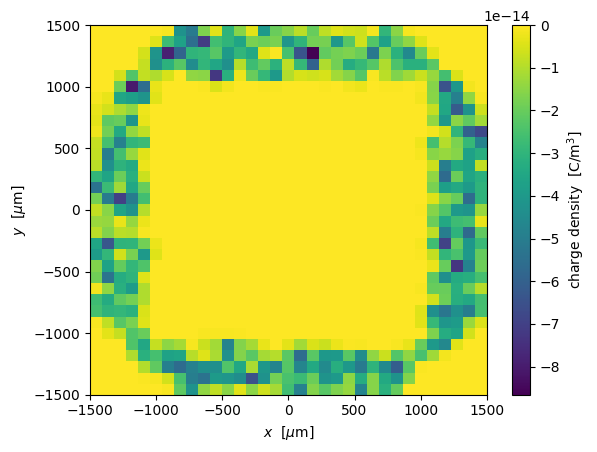

In [53]:
plot_rho(lev=0)

beam_charge=-2.2544966234230275e-10
bx=<amrex.Box of size '(33,33,33)'>
bx=<amrex.Box of size '(17,33,33)'>
bx=<amrex.Box of size '(33,17,33)'>
bx=<amrex.Box of size '(17,17,33)'>


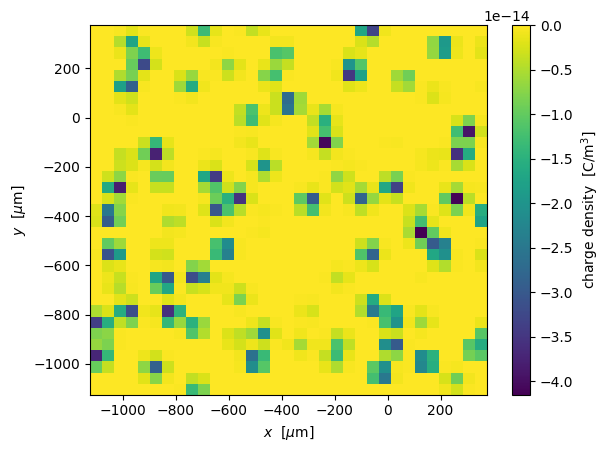

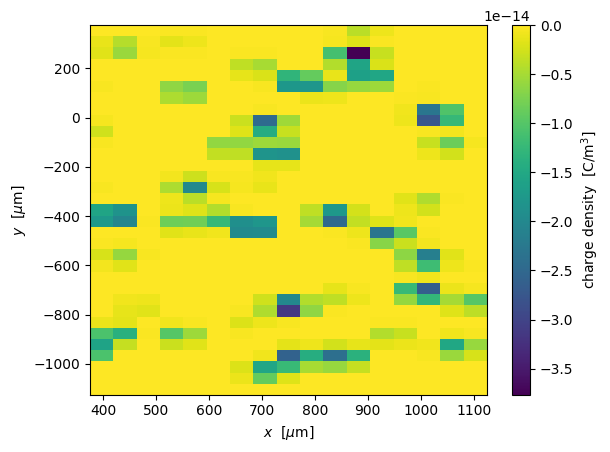

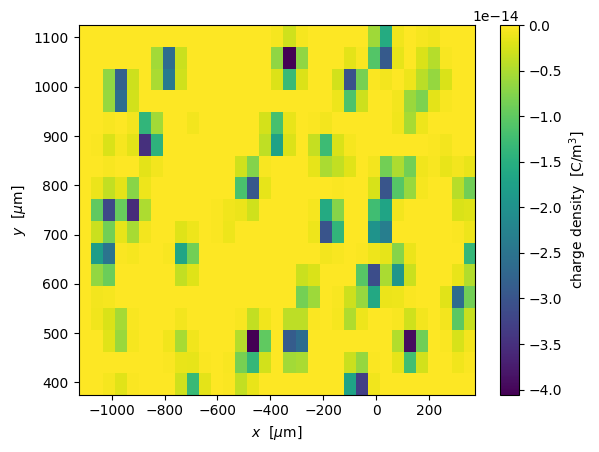

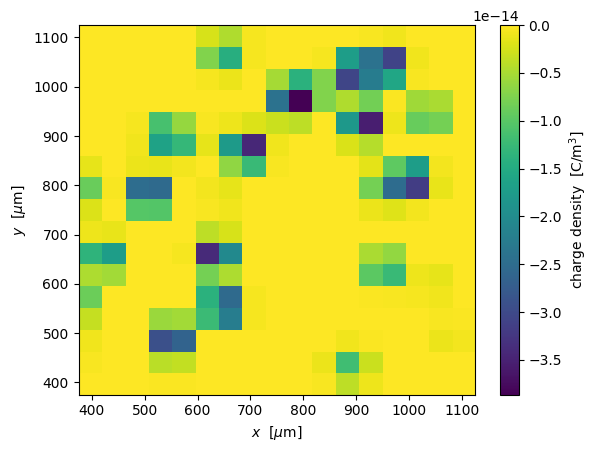

In [54]:
plot_rho(lev=1)